In [42]:
import os
import pandas as pd
import numpy as np
import tqdm
from typing import Tuple

import cv2
import PIL 

import torch
from torch.utils.data import Dataset
import torchvision.transforms as T
from torchvision.io import read_image
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from utils import generate_labels, ImagenetteDataset, get_norm_stats,\
                    get_transforms, train, evaluate, train_pipeline, get_augmented_transforms

from models import Resnet18

from IPython.display import clear_output
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

plt.rcParams['figure.figsize'] = (8.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'

np.random.seed(1234)
torch.manual_seed(1234)


In [38]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=2)

In [40]:
TRAIN_PATH = 'raw/train'
VAL_PATH = 'raw/val'
TRAIN_LABELS_CSV_PATH = 'raw/train/train_labels.csv'
VAL_LABELS_CSV_PATH = 'raw/val/val_labels.csv'

SAVES_PATH = "saves"

AUGMENT = True

SIZE = 224
batch_size = 16

In [43]:
train_labels = pd.read_csv(TRAIN_LABELS_CSV_PATH)
train_labels.drop(columns=['Unnamed: 0'], inplace=True)
val_labels = pd.read_csv(VAL_LABELS_CSV_PATH)
val_labels.drop(columns=['Unnamed: 0'], inplace=True)

mean, std = get_norm_stats(TRAIN_LABELS_CSV_PATH)

train_transform, val_transform = get_transforms(mean, std), get_transforms(mean, std)

train_dataset = ImagenetteDataset(TRAIN_LABELS_CSV_PATH, train_transform)

if AUGMENT:
    augmentation_transform = get_augmented_transforms(mean, std)
    augmented_train_dataset = ImagenetteDataset(TRAIN_LABELS_CSV_PATH, augmentation_transform)
    train_dataset = torch.utils.data.ConcatDataset([train_dataset, augmented_train_dataset])
    
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 

val_dataset = ImagenetteDataset(VAL_LABELS_CSV_PATH, val_transform)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True) 

In [44]:
class_names = [name for name in os.listdir(TRAIN_PATH) if name not in ['.ipynb_checkpoints', 'train_labels.csv']]
num_to_name = dict(zip(range(len(class_names)), class_names))

In [45]:
N_EPOCHS=10

In [46]:
del resnet

In [47]:
resnet = Resnet18()
resnet.to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=1e-4, weight_decay=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, min_lr=1e-7)

In [ ]:
# ckpt = torch.load('saves/ckpts/resnet18_model.pt')
# resnet = Resnet18()
# resnet.load_state_dict(ckpt)
# resnet.to(device)
# optimizer = optim.Adam(resnet.parameters(), lr=1e-4, weight_decay=5e-4)

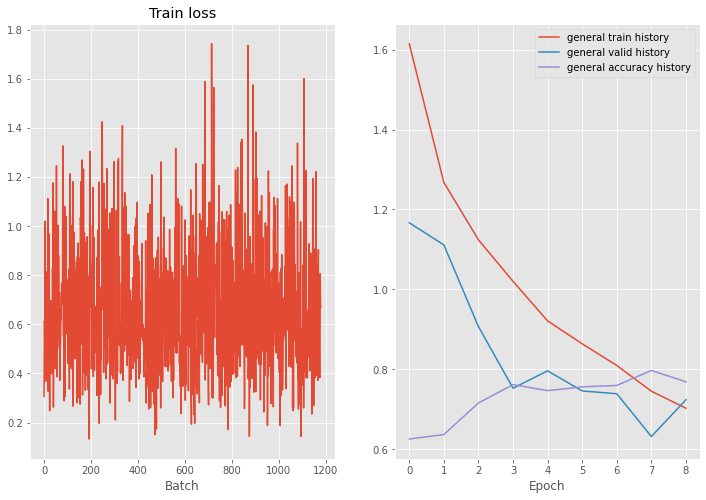

In [48]:
train_pipeline(n_epochs=N_EPOCHS, model=resnet, train_iterator=train_dataloader, val_iterator=val_dataloader,
               optimizer=optimizer, criterion=loss, saves_path=SAVES_PATH,
               num_to_name=num_to_name, device=device, scheduler=scheduler, model_name='resnet18_aug')

In [20]:
import pickle
with open('saves/losses/accuracy_resnet18.pickle', 'rb') as f:
    accuracy_history = pickle.load(f)
print(accuracy_history[-1])

0.8145222929936305


In [21]:
with open('saves/losses/accuracy_resnet18_add.pickle', 'rb') as f:
    accuracy_history = pickle.load(f)
print(accuracy_history[-1])

0.8394904458598726


In [22]:
with open('saves/predictions/predictions_resnet18_add.csv', 'r') as f:
    predictions = pd.read_csv(f)
predictions.head()

,Unnamed: 0,true_num,pred_num,true_name,pred_name
0,0,4,4,парашют,парашют
1,1,8,8,труба,труба
2,2,3,9,язь,резня
3,3,2,2,туц,туц
4,4,7,7,гольфомяч,гольфомяч
